In [1]:
# First off - load all python libraries we are going to need
import pandas as pd
import numpy as np
import os
#import plotly.plotly as py
#import plotly.graph_objs as go


from google.colab import auth
from google.cloud import bigquery
from google.colab import files

import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
import matplotlib.dates as mdates



from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
!pip install regressors
from regressors import stats    


from sklearn.impute import SimpleImputer

from sklearn import metrics

import statsmodels.api as sm

# !pip install pygam
# from pygam import GAM, s, l , te ,LogisticGAM, LinearGAM

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

# !pip install zepid
# import zepid as zp

#import plotly
#plotly.tools.set_credentials_file(username='harounchahed', api_key='ZHypTc119csyz5p0xWet')

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=6533a98b46ceab25cefb67fe2d8adaaa8cbdaf2072d1ea072c7adaa080717b52
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors


# Data Setup

In [0]:
auth.authenticate_user() #This will allow you to authenticate access to BigQuery4/rwDcMzFm8oGoxefjkisvhYNHOGbb11AmM1WbgDorhC0DBQNExxFg1yI

In [0]:
#This is a method that executes a desired SQL query on the database
project_id='ync-capstones'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [4]:
# Now load the data. In general you'd load the whole set of notes but that would take
# several minutes so for this example we're just going to use a subset
#notes = pd.read_csv('D.csv')
cohort = run_query('''
    select * 
    from `NMB.COHORT_BASELINE_P2`
    ''')

FIO2 = run_query('''
    select * 
    from `NMB.TIME_DEP_CONF_FIO2`
    ''')

SPO2 = run_query('''
    select * 
    from `NMB.TIME_DEP_CONF_SPO2`
    ''')

Treatment_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_TR`
    ''')

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


## Cohort

In [0]:
# cohort = cohort.set_index(['subject_id',	'hadm_id',	'icustay_id'], drop = True)

In [0]:
cohort.mv_starttime = pd.to_datetime(cohort.mv_starttime)
cohort.mv_endtime = pd.to_datetime(cohort.mv_endtime)
cohort.dod = pd.to_datetime(cohort.dod)

In [7]:
cohort.shape # number of patiens
# Sanity check: cohort.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() 

(3820, 30)

In [0]:
# This code fixes few ages that are assigned an age >300 by mistake. We replace these ages with the average age of the dataset.
cohort.loc[cohort.age >= 300, 'age'] = 89

In [0]:
# this code fixes removes unrealistic PEEP values 
cohort = cohort.drop(cohort[cohort.max_peep > 50].index)

In [0]:
cohort["mortality"] = np.where(cohort.dod.notnull(), 1 , 0)

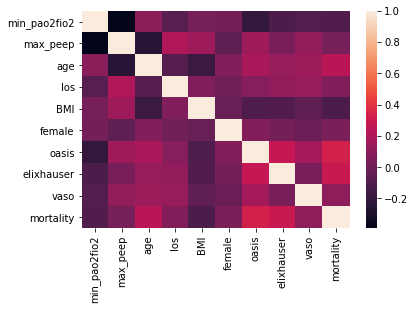

In [11]:
for_cov = cohort[[	"min_pao2fio2",	"max_peep",	"age"	, "los"	, 
                      "BMI"	, "admission_type"	, "admission_location",	
                      "religion" ,	"marital_status",	"ethnicity",	"diagnosis"	,	"female"	, "oasis",
                      "elixhauser",	"vaso",	"mortality"]]
corr = for_cov.corr()
corr_fig = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
#corr_fig.figure.savefig("corr_fig.pdf", bbox_inches='tight', dpi=300)
#files.download("corr_fig.pdf") 

In [12]:
# Dataframe containing only severity and comorbidity scores.
illness = cohort[['oasis', 'elixhauser']]

# Correlation coefficients 
illness.corr()

,oasis,elixhauser
oasis,1.000000,0.277414
elixhauser,0.277414,1.000000


In [13]:
cohort.head()

,subject_id,hadm_id,icustay_id,admittime,dischtime,intime,outtime,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,14572,189993,213815,2197-09-02 03:50:00,2197-09-22 14:35:00,2197-09-07 11:28:48,2197-09-15 13:39:42,116.75,2197-09-07 18:15:00,2197-09-12 15:00:00,140.98361,20.0,45.0,NaT,8.0909,110.0,167.64,39.1,EMERGENCY,EMERGENCY ROOM ADMIT,None,UNOBTAINABLE,SINGLE,WHITE,MYOCARDIAL INFARCTION,1,34,12,0,1,0
1,9385,191454,243100,2200-01-20 21:45:00,2200-01-25 15:08:00,2200-01-20 21:45:34,2200-01-23 22:49:59,10.00,2200-01-21 03:00:00,2200-01-21 13:00:00,67.14286,8.0,48.0,NaT,3.0447,125.0,NaN,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,NOT SPECIFIED,SINGLE,WHITE,ACUTE CHRONIC RESPIRATORY FAILURE,0,30,11,0,0,0
2,23450,122507,294197,2167-03-17 16:40:00,2167-04-29 12:00:00,2167-03-17 16:41:03,2167-04-30 01:11:33,447.00,2167-03-18 01:00:00,2167-04-05 16:00:00,76.66667,13.0,81.0,2167-04-29,43.3545,75.0,163.00,28.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,JEWISH,MARRIED,WHITE,SEPTIC SHOCK,0,51,13,1,1,1
3,30669,168291,228596,2119-11-06 16:37:00,2119-11-28 17:00:00,2119-11-06 16:38:01,2119-11-23 22:26:20,271.00,2119-11-07 10:00:00,2119-11-18 17:00:00,44.00000,11.0,76.0,2120-02-03,17.2419,68.0,160.02,26.6,EMERGENCY,CLINIC REFERRAL/PREMATURE,GREE,GREEK ORTHODOX,MARRIED,WHITE,CONGESTIVE HEART FAILURE,0,35,22,0,1,1
4,40976,119256,214210,2177-11-08 06:39:00,2177-11-17 16:15:00,2177-11-08 06:40:17,2177-11-15 18:28:07,126.00,2177-11-08 19:00:00,2177-11-14 01:00:00,57.00000,10.0,27.0,NaT,7.4916,82.9,178.00,26.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,SINGLE,WHITE,SEPSIS,1,35,-11,1,1,0


## Spo2

Example:

In [0]:
this_hadm = 107822 #
# SPO2.Spo2_charttime = pd.to_datetime(SPO2.Spo2_charttime)

In [0]:
this_hadm_spo2 = SPO2[SPO2.hadm_id == this_hadm]
this_hadm_spo2_indexed =  this_hadm_spo2.set_index('Spo2_charttime')
this_hadm_spo2_resampled = this_hadm_spo2_indexed.resample('1H').first()
# mv_starttime = cohort[cohort.hadm_id == this_hadm].mv_starttime.dt.floor('h')
# mv_endtime = cohort[cohort.hadm_id == this_hadm].mv_endtime.dt.floor('h')
# ix = pd.Series(this_hadm_spo2_resampled.index)
# ix.append([mv_starttime, mv_endtime])
# this_hadm_spo2_resampled.reindex(ix) #add mv starttime and end time to index
this_hadm_spo2_imputed = this_hadm_spo2_resampled.interpolate(method = 'time')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


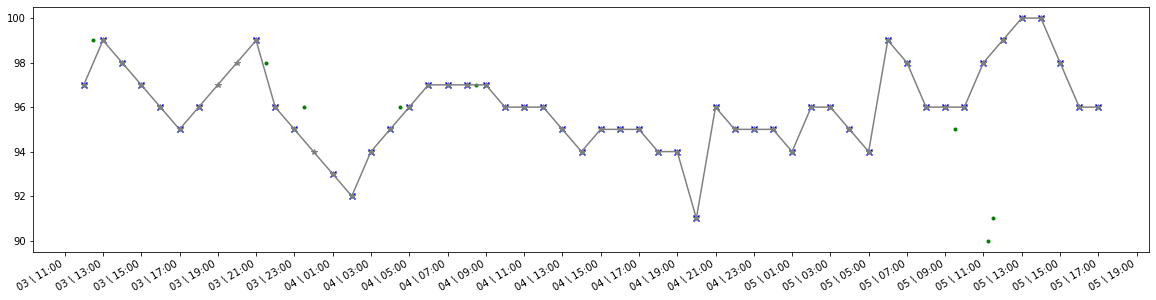

In [16]:
plt.figure(figsize = (20,5))
plt.scatter(this_hadm_spo2_indexed.index, this_hadm_spo2_indexed.Spo2, marker='.', color = 'green')
plt.scatter(this_hadm_spo2_resampled.index,this_hadm_spo2_resampled.Spo2, marker ='x', color = 'blue')
plt.plot(this_hadm_spo2_imputed.index,this_hadm_spo2_imputed.Spo2, marker ="*", color = 'grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d \ %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.show()

In [0]:
def create_Spo2_table(interval, SPO2 = SPO2):
  missing_data = 0
  result = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'mv_durations_hours',
        'mv_starttime', 'mv_endtime', 'Spo2'])
  for hadm_id in cohort.hadm_id: 
    this_hadm_spo2 = SPO2[SPO2.hadm_id == hadm_id] # get SPO2 for one patient
    this_hadm_spo2_indexed =  this_hadm_spo2.set_index('Spo2_charttime') #make SPO2 charttime the index
    this_hadm_spo2_resampled = this_hadm_spo2_indexed.resample(interval).first() # resample to keep first value in every n-hour
    missing_data += pd.isna(this_hadm_spo2_resampled.Spo2).sum()
    this_hadm_spo2_imputed = this_hadm_spo2_resampled.interpolate(method = 'time') # impute missing values using time method (trajectory) 
    this_hadm_spo2_imputed.fillna(method = 'pad', inplace = True) # impute datetime missing values cause they are not imputed using trajectory method
    result = pd.concat([result, this_hadm_spo2_imputed])
  missing_data_rate = missing_data / result.Spo2.count() * 100
  print("For Spo2 table " + interval + " missing data imputed is " + str(missing_data_rate) + "% and number of missing data is " + str(missing_data) + " out of " + str(result.Spo2.count()))
  return result

In [18]:
SPO2_1H = create_Spo2_table('1H', SPO2 = SPO2)
SPO2_2H = create_Spo2_table('2H', SPO2 = SPO2)
SPO2_3H = create_Spo2_table('3H', SPO2 = SPO2)
SPO2_4H = create_Spo2_table('4H', SPO2 = SPO2)
SPO2_5H = create_Spo2_table('5H', SPO2 = SPO2)

For Spo2 table 1H missing data imputed is 4.21673347613959% and number of missing data is 17441 out of 413614
For Spo2 table 2H missing data imputed is 1.2558576343302892% and number of missing data is 2621 out of 208702
For Spo2 table 3H missing data imputed is 0.7199572725654264% and number of missing data is 1011 out of 140425
For Spo2 table 4H missing data imputed is 0.49564546771250684% and number of missing data is 527 out of 106326
For Spo2 table 5H missing data imputed is 0.36738121340766483% and number of missing data is 315 out of 85742


## Fio2

Example

In [0]:
FIO2.Fio2_charttime = pd.to_datetime(FIO2.Fio2_charttime)

In [0]:
this_hadm = 107822 #

this_hadm_fio2 = FIO2[FIO2.hadm_id == this_hadm]
this_hadm_fio2_indexed =  this_hadm_fio2.set_index('Fio2_charttime')
this_hadm_fio2_resampled = this_hadm_fio2_indexed.resample('1H').first()
# mv_starttime = cohort[cohort.hadm_id == this_hadm].mv_starttime.dt.floor('h')
# mv_endtime = cohort[cohort.hadm_id == this_hadm].mv_endtime.dt.floor('h')
# ix = pd.Series(this_hadm_fio2_resampled.index)
# ix.append([mv_starttime, mv_endtime])
# this_hadm_fio2_resampled.reindex(ix) #add mv starttime and end time to index
this_hadm_fio2_imputed = this_hadm_fio2_resampled.interpolate(method = 'time')


plt.figure(figsize = (20,5))
plt.scatter(this_hadm_fio2_indexed.index, this_hadm_fio2_indexed.Fio2, marker='.', color = 'green')
plt.scatter(this_hadm_fio2_resampled.index,this_hadm_fio2_resampled.Fio2, marker ='x', color = 'blue')
plt.plot(this_hadm_fio2_imputed.index,this_hadm_fio2_imputed.Fio2, marker ="*", color = 'grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d \ %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.show()

In [0]:
def create_Fio2_table(interval, FIO2 = FIO2):
  missing_data = 0
  result = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'mv_durations_hours',
        'mv_starttime', 'mv_endtime', 'Fio2'])
  for hadm_id in cohort.hadm_id: 
    this_hadm_fio2 = FIO2[FIO2.hadm_id == hadm_id] # get FIO2 for one patient
    this_hadm_fio2_indexed =  this_hadm_fio2.set_index('Fio2_charttime') #make FIO2 charttime the index
    this_hadm_fio2_resampled = this_hadm_fio2_indexed.resample(interval).first() # resample to keep first value in every n-hour
    missing_data += pd.isna(this_hadm_fio2_resampled.Fio2).sum()
    this_hadm_fio2_imputed = this_hadm_fio2_resampled.interpolate(method = 'time') # impute missing values using time method (trajectory) 
    this_hadm_fio2_imputed.fillna(method = 'pad', inplace = True) # impute datetime missing values cause they are not imputed using trajectory method
    result = pd.concat([result, this_hadm_fio2_imputed])
  missing_data_rate = missing_data / result.Fio2.count() * 100
  print("For Fio2 table " + interval + " missing data imputed is " + str(missing_data_rate) + "% and number of missing data is " + str(missing_data) + " out of " + str(result.Fio2.count()))
  return result

In [0]:
FIO2_1H = create_Fio2_table('1H', FIO2 = FIO2)
FIO2_2H = create_Fio2_table('2H', FIO2 = FIO2)
FIO2_3H = create_Fio2_table('3H', FIO2 = FIO2)
FIO2_4H = create_Fio2_table('4H', FIO2 = FIO2)
FIO2_5H = create_Fio2_table('5H', FIO2 = FIO2)

## SF ratio

In [0]:
def compute_PF(SPO2, FIO2): 
  SPO2 = SPO2.set_index(['hadm_id'], append=True, drop = False)
  FIO2 = FIO2.set_index(['hadm_id'], append=True, drop = False) 
  idx =  SPO2.index.intersection(FIO2.index)
  SPO2.reindex(idx)
  FIO2.reindex(idx)
  SPO2["Fio2"] = FIO2.Fio2
  SPO2["SF_ratio"] = SPO2.Spo2 / SPO2.Fio2
  result = SPO2.dropna() 
  return result

In [0]:
SF_1H = compute_PF(SPO2_1H, FIO2_1H)
SF_2H = compute_PF(SPO2_2H, FIO2_2H)
SF_3H = compute_PF(SPO2_3H, FIO2_3H)
SF_4H = compute_PF(SPO2_4H, FIO2_4H)
SF_5H = compute_PF(SPO2_5H, FIO2_5H)

In [0]:
SF_1H #394678

## Treatment

In [0]:
Treatment_raw.mv_starttime = pd.to_datetime(Treatment_raw.mv_starttime)
Treatment_raw.mv_endtime = pd.to_datetime(Treatment_raw.mv_endtime)
Treatment_raw.NMBA_timestamp = pd.to_datetime(Treatment_raw.NMBA_timestamp)

In [0]:
Treatment_raw.head()

In [0]:
def create_treatment_table(interval, Treatment_raw = Treatment_raw):
  result = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'mv_durations_hours', 'mv_starttime', 'mv_endtime', 'NMBA_amount'])
  for hadm_id in cohort.hadm_id: 
    this_hadm_trt = Treatment_raw[Treatment_raw.hadm_id == hadm_id] # get trt for one patient
    this_hadm_trt_indexed =  this_hadm_trt.set_index('NMBA_timestamp') #make trt charttime the index
    this_hadm_trt_resampled = this_hadm_trt_indexed.resample(interval).first() # resample to keep first value in every n-hour for all values except trt
    NMBA_count = this_hadm_trt_indexed.hadm_id.resample(interval).count()  # count number of treatment
    this_hadm_trt_resampled.NMBA_amount = NMBA_count
    this_hadm_trt_resampled.fillna(method = 'pad', inplace = True)
    result = pd.concat([result, this_hadm_trt_resampled])
  return result

In [0]:
TRT_1H = create_treatment_table('1H', Treatment_raw) 
TRT_2H = create_treatment_table('2H', Treatment_raw)
TRT_3H = create_treatment_table('3H', Treatment_raw)
TRT_4H = create_treatment_table('4H', Treatment_raw)
TRT_5H = create_treatment_table('5H', Treatment_raw)

## MSM_table_1H

In [0]:
def add_trt_inforomation(SF = SF_1H, TRT = TRT_1H):
  Treatment = TRT.set_index(['hadm_id'], append=True, drop = False)
  MSM_table = SF
  MSM_table['NMBA_count'] = Treatment.NMBA_amount
  MSM_table['tr_t'] = np.where((pd.isnull(MSM_table['NMBA_count'])) | (MSM_table['NMBA_count'] == 0), 0, 1) # | stands for 'or'
  MSM_table['tr_t_min_1'] = 0
  MSM_table.tr_t_min_1[1:] = MSM_table.tr_t[:-1]
  return MSM_table

In [0]:
MSM_table_1H = add_trt_inforomation(SF_1H, TRT_1H) 
MSM_table_2H = add_trt_inforomation(SF_2H, TRT_2H) 
MSM_table_3H = add_trt_inforomation(SF_3H, TRT_3H) 
MSM_table_4H = add_trt_inforomation(SF_4H, TRT_4H) 
MSM_table_5H = add_trt_inforomation(SF_5H, TRT_5H) 

In [0]:
def drop_y(df):
    # list comprehension of the cols that end with '_x'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

In [0]:
def add_baseline_covariates(MSM_table, cohort):
  MSM_table.reset_index(drop = True, inplace = True) # at this point we lose hour information
  MSM_table = MSM_table.merge(cohort, on = ['subject_id',	'hadm_id', 'icustay_id'])
  drop_y(MSM_table)
  return MSM_table

In [0]:
MSM_table_1H = add_baseline_covariates(MSM_table_1H, cohort) 
MSM_table_2H = add_baseline_covariates(MSM_table_2H, cohort) 
MSM_table_3H = add_baseline_covariates(MSM_table_3H, cohort) 
MSM_table_4H = add_baseline_covariates(MSM_table_4H, cohort) 
MSM_table_5H = add_baseline_covariates(MSM_table_5H, cohort) 

In [0]:
MSM_table_1H

# MSM

## IPTW

In [0]:
MSM_table_1H.tr_t = MSM_table_1H.tr_t.astype(int)
MSM_table_1H.tr_t_min_1 = MSM_table_1H.tr_t_min_1.astype(int)
# MSM_table_1H.death_t = MSM_table_1H.death_t.astype(int)

MSM_table_2H.tr_t = MSM_table_2H.tr_t.astype(int)
MSM_table_2H.tr_t_min_1 = MSM_table_2H.tr_t_min_1.astype(int)
# MSM_table_2H.death_t = MSM_table_2H.death_t.astype(int)

MSM_table_3H.tr_t = MSM_table_3H.tr_t.astype(int)
MSM_table_3H.tr_t_min_1 = MSM_table_3H.tr_t_min_1.astype(int)
# MSM_table_3H.death_t = MSM_table_3H.death_t.astype(int)

MSM_table_4H.tr_t = MSM_table_4H.tr_t.astype(int)
MSM_table_4H.tr_t_min_1 = MSM_table_4H.tr_t_min_1.astype(int)
# MSM_table_4H.death_t = MSM_table_4H.death_t.astype(int)

MSM_table_5H.tr_t = MSM_table_5H.tr_t.astype(int)
MSM_table_5H.tr_t_min_1 = MSM_table_5H.tr_t_min_1.astype(int)
# MSM_table_5H.death_t = MSM_table_5H.death_t.astype(int)

In [0]:
def den_model(MSM_table):
  y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=MSM_table, return_type='dataframe')
  # y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
  logit_model_den = sm.Logit(y,X)
  fitted_model_den=logit_model_den.fit()
  print(fitted_model_den.summary())
  return fitted_model_den

In [0]:
def nom_model(MSM_table):
  y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = MSM_table, return_type='dataframe')
  logit_model_nom = sm.Logit(y,X)
  fitted_model_nom = logit_model_nom.fit()
  print(fitted_model_nom.summary())
  return fitted_model_nom

In [0]:
fitted_model_den_1H = den_model(MSM_table_1H)
fitted_model_nom_1H = nom_model(MSM_table_1H)
fitted_model_den_2H = den_model(MSM_table_2H)
fitted_model_nom_2H = nom_model(MSM_table_2H)
fitted_model_den_3H = den_model(MSM_table_3H)
fitted_model_nom_3H = nom_model(MSM_table_3H)
fitted_model_den_4H = den_model(MSM_table_4H)
fitted_model_nom_4H = nom_model(MSM_table_4H)
fitted_model_den_5H = den_model(MSM_table_5H)
fitted_model_nom_5H = nom_model(MSM_table_5H)

In [0]:
def add_IPTW(MSM_table, fitted_model_nom, fitted_model_den):

  MSM_table["den"] = np.nan
  MSM_table["nom"] = np.nan
  cols = MSM_table.columns
  BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
  TDC = ['SF_ratio', 'tr_t_min_1']
  patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
  BC_index = [MSM_table.columns.get_loc(c) for c in cols if c in BC]
  TDC_index = [MSM_table.columns.get_loc(c) for c in cols if c in TDC]
  patient_id_index = [MSM_table.columns.get_loc(c) for c in cols if c in patient_id]
  den_index = MSM_table.columns.get_loc("den")
  nom_index = MSM_table.columns.get_loc("nom")
  trt_index = MSM_table.columns.get_loc("tr_t")

  for i in range(len(MSM_table)):
    if i == 0: 
      BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] #This is for the first row
      if MSM_table.iloc[i, trt_index] == 1: # if treated
        MSM_table.iloc[i, nom_index] = BC_prob # get probability treatment
        MSM_table.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        MSM_table.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        MSM_table.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
    else: # if not first row
      if (MSM_table.iloc[i, patient_id_index] == MSM_table.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
        sing_BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] 
        sing_TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] 
        if MSM_table.iloc[i, trt_index] == 1: # if treated
          MSM_table.iloc[i, nom_index] = sing_BC_prob * MSM_table.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
          MSM_table.iloc[i, den_index] = sing_TDC_prob * MSM_table.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
        else:  # if not treated
          MSM_table.iloc[i, nom_index] = (1 - sing_BC_prob) * MSM_table.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
          MSM_table.iloc[i, den_index] = (1 - sing_TDC_prob) * MSM_table.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
      else: # if not same patient
        BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] #This is for the first row
        TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] #This is for the first row
        if MSM_table.iloc[i, trt_index] == 1: # if treated
          MSM_table.iloc[i, nom_index] = BC_prob # get probability treatment
          MSM_table.iloc[i, den_index] = TDC_prob # get probability treatment
        else:  # if not treated
          MSM_table.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
          MSM_table.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  MSM_table['IPTW'] = MSM_table.nom / MSM_table.den
  print("Done!\n")
  return MSM_table

In [0]:
MSM_table_1H = add_IPTW(MSM_table_1H, fitted_model_nom_1H, fitted_model_den_1H)
MSM_table_2H = add_IPTW(MSM_table_2H, fitted_model_nom_2H, fitted_model_den_2H)
MSM_table_3H = add_IPTW(MSM_table_3H, fitted_model_nom_3H, fitted_model_den_3H)
MSM_table_4H = add_IPTW(MSM_table_4H, fitted_model_nom_4H, fitted_model_den_4H)
MSM_table_5H = add_IPTW(MSM_table_5H, fitted_model_nom_5H, fitted_model_den_5H)
# N.B: Computing IPTW for all 5 tables takes around 3 hours

In [0]:
def add_death(MSM_table, cohort): 
  # MSM_table.drop(columns=['ICU_death', 'hos_death', 'ICU30_death', 'ICU90_death'], inplace=True)
  result = pd.DataFrame(columns = np.concatenate((np.array(MSM_table.columns), np.array(['MV30_death', 'ICU_death', 'hos_death', 'ICU30_death', 'ICU90_death']))))
  for this_hadm_id in cohort.hadm_id:
    #print(this_hadm_id)
    this_MSM = MSM_table[MSM_table.hadm_id == this_hadm_id]

     # death before ICU discharge
    this_MSM['MV30_death'] = 0 
    if pd.notnull(cohort[cohort.hadm_id == this_hadm_id].dod).any(): 
      limit_death_date = cohort[cohort.hadm_id == this_hadm_id].mv_starttime + pd.Timedelta(days=30)
      if (cohort[cohort.hadm_id == this_hadm_id].dod < limit_death_date).any():
        if len(this_MSM):
          this_MSM.iloc[-1, this_MSM.columns.get_loc('MV30_death')] = 1
          
    # death before ICU discharge
    this_MSM['ICU_death'] = 0 
    if pd.notnull(cohort[cohort.hadm_id == this_hadm_id].dod).any(): 
      limit_death_date = cohort[cohort.hadm_id == this_hadm_id].outtime
      if (cohort[cohort.hadm_id == this_hadm_id].dod < limit_death_date).any():
        if len(this_MSM):
          this_MSM.iloc[-1, this_MSM.columns.get_loc('ICU_death')] = 1

    # death before hospital dischage 
    this_MSM['hos_death'] = 0 
    if pd.notnull(cohort[cohort.hadm_id == this_hadm_id].dod).any(): 
      limit_death_date = cohort[cohort.hadm_id == this_hadm_id].dischtime
      if (cohort[cohort.hadm_id == this_hadm_id].dod < limit_death_date).any():
        if len(this_MSM):
          this_MSM.iloc[-1, this_MSM.columns.get_loc('hos_death')] = 1

    # 30 day from ICU admission
    this_MSM['ICU30_death'] = 0 
    if pd.notnull(cohort[cohort.hadm_id == this_hadm_id].dod).any(): 
      limit_death_date = cohort[cohort.hadm_id == this_hadm_id].intime + pd.Timedelta(days=30)
      if (cohort[cohort.hadm_id == this_hadm_id].dod < limit_death_date).any():
        if len(this_MSM):
          this_MSM.iloc[-1, this_MSM.columns.get_loc('ICU30_death')] = 1

    # 90 days from hospital admission
    this_MSM['ICU90_death'] = 0 
    if pd.notnull(cohort[cohort.hadm_id == this_hadm_id].dod).any(): 
      limit_death_date = cohort[cohort.hadm_id == this_hadm_id].intime + pd.Timedelta(days=90)
      if (cohort[cohort.hadm_id == this_hadm_id].dod < limit_death_date).any():
        if len(this_MSM):
          this_MSM.iloc[-1, this_MSM.columns.get_loc('ICU90_death')] = 1

    result = pd.concat([result, this_MSM])
  return result

In [0]:
MSM_table_1H = add_death(MSM_table_1H, cohort)
MSM_table_2H = add_death(MSM_table_2H, cohort)
MSM_table_3H = add_death(MSM_table_3H, cohort)
MSM_table_4H = add_death(MSM_table_4H, cohort)
MSM_table_5H = add_death(MSM_table_5H, cohort)

In [0]:
MSM_table_1H

In [0]:
# MSM_table_1H.to_csv("MSM_table_1H.csv")
# MSM_table_2H.to_csv("MSM_table_2H.csv")
# MSM_table_3H.to_csv("MSM_table_3H.csv")
# MSM_table_4H.to_csv("MSM_table_4H.csv")
# MSM_table_5H.to_csv("MSM_table_5H.csv")

from google.colab import drive
drive.mount('/content/drive')

In [0]:
MSM_table_1H_location = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table_1H.csv"
MSM_table_2H_location = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table_2H.csv"
MSM_table_3H_location = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table_3H.csv"
MSM_table_4H_location = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table_4H.csv"
MSM_table_5H_location = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table_5H.csv"

MSM_table_1H.to_csv(MSM_table_1H_location)
MSM_table_2H.to_csv(MSM_table_2H_location)
MSM_table_3H.to_csv(MSM_table_3H_location)
MSM_table_4H.to_csv(MSM_table_4H_location)
MSM_table_5H.to_csv(MSM_table_5H_location)